In [1]:
from sklearn.cluster import DBSCAN


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
# import numpy as np
import pandas as pd

In [3]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os
from degree_days import dds
import autograd.numpy as np




def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [4]:
def get_tensor(df):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    dfc = df.copy()

    df = dfc[energy_cols]

    tensor = df.values.reshape((len(df), 7, stop - start))
    return tensor


def create_region_df_dfc_static(region, year):
    df, dfc = create_matrix_single_region(region, year)
    tensor = get_tensor(df)
    static_region = df[['area', 'total_occupants', 'num_rooms']].copy()
    static_region['area'] = static_region['area'].div(4000)
    static_region['total_occupants'] = static_region['total_occupants'].div(8)
    static_region['num_rooms'] = static_region['num_rooms'].div(8)
    static_region =static_region.values
    return df, dfc, tensor, static_region


In [5]:
def get_L_NN(X):
    nbrs = NearestNeighbors(n_neighbors=5, radius = 0.1, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    n_sample, n_feature = X.shape
    W = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        if distances[i][4] == 0:
            continue
        for j in indices[i]:
            W[i][j] = 1
            W[j][i] = 1
    K = np.dot(W, np.ones((n_sample, n_sample)))
    D = np.diag(np.diag(K))
#     print W
    return D - W

In [6]:
def distance(x, y):
    return np.linalg.norm(x - y)

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
from sklearn.metrics.pairwise import pairwise_distances

In [9]:
def cost_graph_laplacian(H, A, T, L, E_np_masked, lam, case):
    HAT = multiply_case(H, A, T, case)
    mask = ~np.isnan(E_np_masked)
    error_1 = (HAT - E_np_masked)[mask].flatten()
    
    HTL = np.dot(H.T, L)
    HTLH = np.dot(HTL, H)
    error_2 = np.trace(HTLH)
    
    return np.sqrt((error_1**2).mean()) + lam * error_2

In [10]:
def learn_HAT_adagrad_graph(case, E_np_masked, L, a, b, num_iter=2000, lr=0.1, dis=False, lam = 1, H_known=None,
                      A_known=None, T_known=None, random_seed=0, eps=1e-8, penalty_coeff=0.0):

    np.random.seed(random_seed)
    cost = cost_graph_laplacian
    mg = multigrad(cost, argnums=[0, 1, 2])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    
    H = np.random.rand(*H_dim)
    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)

    sum_square_gradients_H = np.zeros_like(H)
    sum_square_gradients_A = np.zeros_like(A)
    sum_square_gradients_T = np.zeros_like(T)

    Hs = [H.copy()]
    As = [A.copy()]
    Ts = [T.copy()]
    
    costs = [cost(H, A, T, L, E_np_masked, lam, case)]
    HATs = [multiply_case(H, A, T, case)]

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, L, E_np_masked, lam, case)
        sum_square_gradients_H += eps + np.square(del_h)
        sum_square_gradients_A += eps + np.square(del_a)
        sum_square_gradients_T += eps + np.square(del_t)
    

        lr_h = np.divide(lr, np.sqrt(sum_square_gradients_H))
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))
        lr_t = np.divide(lr, np.sqrt(sum_square_gradients_T))

        H -= lr_h * del_h
        A -= lr_a * del_a
        T -= lr_t * del_t
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        # Projection to non-negative space
        H[H < 0] = 1e-8
        A[A < 0] = 1e-8
        T[T < 0] = 1e-8

        As.append(A.copy())
        Ts.append(T.copy())
        Hs.append(H.copy())
        
        costs.append(cost(H, A, T, L, E_np_masked, lam, case))
        
        HATs.append(multiply_case(H, A, T, case))
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, L, E_np_masked, lam, case))
    return H, A, T, Hs, As, Ts, HATs, costs

In [11]:
au_df, au_dfc, au_tensor, au_static = create_region_df_dfc_static('Austin', year)
sd_df, sd_dfc, sd_tensor, sd_static = create_region_df_dfc_static('SanDiego', year)


In [12]:
au_agg = au_df.loc[:, 'aggregate_1':'aggregate_12'].copy()
au_agg = np.nan_to_num(au_agg)

In [13]:
from scipy.spatial.distance import pdist, squareform
pdist(sd_static, "euclidean").shape

(741,)

In [14]:
def get_L(X):
    W = 1-squareform(pdist(X, 'cosine'))
    W = np.nan_to_num(W)
    n_sample, n_feature = W.shape
    
    K = np.dot(W, np.ones((n_sample, n_sample)))
    D = np.diag(np.diag(K))
    return D - W

In [15]:
L_au = get_L(au_static)
L_sd = get_L(sd_static)

In [18]:
np.trace(L_sd)

53.913777341648334

In [130]:

case = 2
a, b = 1, 3
H_sds={}
for a in range(1, 4):
    H_sds[a] = {}
    for lam in [0, 1e-5, 1e-3, 1e-1, 1, 1e2, 1e5, 1e10]:
        print(lam, a)
        H_sd, A_sd, T_sd, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, sd_tensor, L_sd, a, b, num_iter=1000, lr=1, dis=False, lam=lam)
        H_sds[a][lam] = H_sd

(0, 1)
(1e-05, 1)
(0.001, 1)
(0.1, 1)
(1, 1)
(100.0, 1)
(100000.0, 1)
(10000000000.0, 1)
(0, 2)
(1e-05, 2)
(0.001, 2)
(0.1, 2)
(1, 2)
(100.0, 2)
(100000.0, 2)
(10000000000.0, 2)
(0, 3)
(1e-05, 3)
(0.001, 3)
(0.1, 3)
(1, 3)
(100.0, 3)
(100000.0, 3)
(10000000000.0, 3)


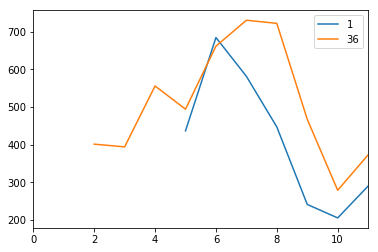

In [106]:
energy = pd.DataFrame({'1':sd_tensor[1][0,:], '36':sd_tensor[36][0,:]})
energy.plot()

In [105]:
sd_static[[1, 36]]

array([[ 0.38875,      nan,      nan],
       [ 0.38875,      nan,      nan]])

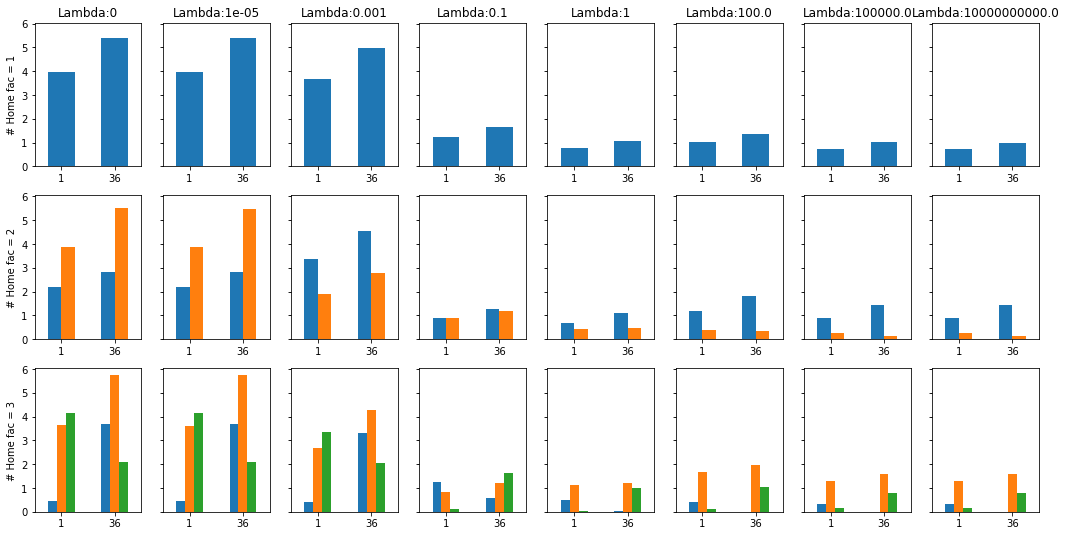

In [133]:
fig, ax = plt.subplots(ncols=8, nrows=3, sharey=True, figsize=(18, 9))
for row, a in enumerate(range(1, 4)):
    ax[row, 0].set_ylabel("# Home fac = {}".format(a))
    for col, lam in enumerate([0, 1e-5, 1e-3, 1e-1, 1, 1e2, 1e5, 1e10]):
        ax[0, col].set_title("Lambda:"+str(lam))
        pd.DataFrame(H_sds[a][lam]).loc[[1, 36]].plot(ax=ax[row, col], kind='bar', legend=False, rot=0)

In [84]:
X = sd_static
np.nan_to_num(1-squareform(pdist(X, 'cosine')))

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [85]:
pd.DataFrame(sd_static)

,0,1,2
0,NaN,NaN,NaN
1,0.38875,NaN,NaN
2,NaN,NaN,NaN
3,0.39375,NaN,NaN
4,0.51250,NaN,NaN
5,0.38875,0.250,0.500
6,NaN,NaN,NaN
7,0.54500,NaN,NaN
8,0.34750,0.250,0.500
9,NaN,NaN,NaN


In [86]:
pd.DataFrame(H_sd).head()

,0
0,3.388509
1,3.973967
2,9.011626
3,8.201847
4,7.260936


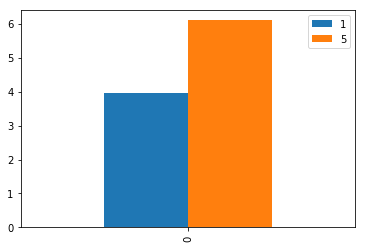

In [87]:
pd.DataFrame(H_sd).loc[[1, 5]].T.plot(kind='bar')

In [152]:
H_au, A_au, T_au, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, au_tensor, L_au, a, b, num_iter=2000, lr=0.1, dis=False, lam=lam, T_known = np.ones(12).reshape(-1, 1))

In [154]:
n_splits = 10
pred_normal = {}
pred_transfer = {}
for random_seed in range(5):
    pred_normal[random_seed] = {}
    pred_transfer[random_seed] = {}
    
    for appliance in APPLIANCES_ORDER:
        pred_normal[random_seed][appliance] = {f:[] for f in range(10, 110, 20)}
        pred_transfer[random_seed][appliance] = {f:[] for f in range(10, 110, 20)}

kf = KFold(n_splits=n_splits)
for random_seed in range(5):
    print "random seed: ", random_seed
    np.random.seed(random_seed)
    # H_au, A_au, T_au, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, au_tensor, L_au, a, b, num_iter=2000, lr=0.1, dis=False, lam=lam, T_known = np.ones(12).reshape(-1, 1), random_seed = random_seed)
    for train_percentage in range(10, 110, 20):
        print "training percentage: ", train_percentage
        rd = 0
        
        for train_max, test in kf.split(sd_df):
            print "round: ", rd
           
            
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t)

            
            ############################################################################################
            # Normal learning: no constant constraint, no A_known, with learn_HAT
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
            # agg = sd_agg[np.concatenate([test_ix, train_ix])]
            L = L_sd[np.ix_(np.concatenate([test, train]), np.concatenate([test, train]))]

#             H, A, T, F = learn_HAT_graph(2, tensor_copy, static_sd[np.concatenate([test, train])], sim_sd, a, b, num_iter=iters,dis=False, T_known = np.ones(12).reshape(-1, 1))
            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, L, a, b, num_iter=2000, lr=0.1, dis=False, lam=lam, T_known = np.ones(12).reshape(-1, 1))
            
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_normal[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))     

            ############################################################################################
            # transfer learning: constant constraint, with A_known = A_a_const, with learn_HAT_constant
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
            # agg = sd_agg[np.concatenate([test, train])]
            L = L_sd[np.ix_(np.concatenate([test, train]), np.concatenate([test, train]))]
            
#             H, A, T, F = learn_HAT_graph(2, tensor_copy, static_sd[np.concatenate([test, train])], sim_sd, a, b, num_iter=iters,dis=False, T_known = np.ones(12).reshape(-1, 1))
#             H, A, T, F, Hs, As, Ts, Fs, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, L, agg, a, b, num_iter=20000, lr=0.1, dis=False,A_known = A_au)
            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, L, a, b, num_iter=2000, lr=0.1, dis=False, lam=lam, A_known = A_au, T_known = np.ones(12).reshape(-1, 1))

      
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_transfer[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
            
            
            rd += 1


random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')


/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  30
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909,